In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import exposure
import glob
#show matplot images inline
%matplotlib inline

# Get images

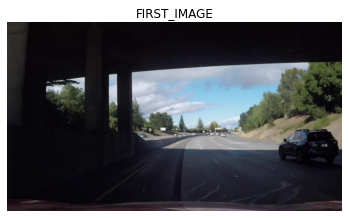

In [2]:
def show_image(image,title="image",cmap_type="gray",axis='off'):
    plt.imshow(image,cmap_type)
    plt.title(title)
    plt.axis(axis)
#LOADING ALL IMAGES FROM TEST_IMAGES FILE
images = glob.glob("test_images/*.jpg")
images = [plt.imread(image) for image in images] 

show_image(images[0],"FIRST_IMAGE")

# Helper Functions

In [3]:
def gaussian_blur(img,kernel_size=5):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),#5x5 I guess
                  0)
# Histogram Equalizer
def hist_equalizer(img):
    equ = cv2.equalizeHist(img)
    return equ
def draw_roi(img,isClosed=True,color=(255,0,0),thickness=5):
    x,y = (img.shape[1],img.shape[0])
    pts = np.array([[0,y-1], [0.5*x,int(0.5*y)],
                [x-1,y-1], [x-1,y-1]],
               np.int32)
    pts = pts.reshape((-1, 1, 2))
    img = cv2.polylines(img, [pts], 
                      isClosed, color, 
                      thickness)
    return img


In [4]:
def perspective_transform(img,dst_size=(1280,720),inv=0):
    img_size=np.float32([(img.shape[1],img.shape[0])])
    #Region of Interest
    #Order is top left, top right, bottom left, bottom right
    src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    srcPoints = src*img_size
    dstPoints = dst*np.float32(dst_size)
    if(inv):
        M = cv2.getPerspectiveTransform(dstPoints,srcPoints) #inverse
    else:
        M = cv2.getPerspectiveTransform(srcPoints,dstPoints) #Returns a matrix that transforms an Image
    warped_image = cv2.warpPerspective(img,M,dst_size)
    return warped_image 

In [5]:
def top_hat_filter(img):
#     img = gaussian_blur(img,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(27,27))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    mask = np.zeros_like(tophat)
    mask[((tophat > 10)&(tophat<=150))] = 1
    kernel = np.ones((10,5),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1)
#     kernel = np.ones((100,13),np.uint8)
#     mask = cv2.dilate(mask,kernel,iterations = 1)

    return mask
#     return mask.astype(np.uint8)  
def pipeline(img,s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = np.copy(img)
    height, width= 1200, 1200
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    v_channel= hsv[:,:,2]
    ####################################################
    warped_image = perspective_transform(l_channel, dst_size=(1280,720),inv=0)
    warped_image2 = perspective_transform(v_channel, dst_size=(1280,720),inv=0)
    mask = top_hat_filter(warped_image)
    mask2 = top_hat_filter(warped_image2)
    b4mask = cv2.bitwise_or(mask,mask2)
    
    b4mask[b4mask.shape[0]//2:b4mask.shape[0],350:850] = 0
    kernel = np.ones((5,1),np.uint8)
    a4mask = cv2.erode(b4mask,kernel,iterations = 2)

    return a4mask
    ####################################################

In [ ]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

# Sliding Window

In [ ]:
#Globally defined to store the parameters of past images
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]
def sliding_window(img, 
                   nwindows=9, #Number of windows 
                   margin=150, #half window width 100?
                   minpix = 1 #minimum number of pixels to recenter the window 50? 
                  ):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3) #parameters of 2nd order polynomial
    right_fit_ = np.empty(3) 
    out_img = np.dstack((img, img, img))*255 #Converts binary to 3 dimensional channel normal RGB
    
    #USING HISTOGRAM METHOD
    histogram = get_hist(img) 
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # Indices in image is the coordinates the row is the height is the y
    # the column is the width is the x
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        
        #Get non-zero pixels within each window by getting the indices of nonzerox
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] 
        #[0] get indices of nonzerox only but you can access nonzeroy with it too
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ''' 
        minpix is used to recenter the window and depends on how good the filter is
        if minpix is low it might be affected by the noise(?)
        therefore we keep minpix at 50 pixels for now to only recenter in the direction of any solid line
        '''
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices
    #All pixels within all 9 windows
    left_lane_inds = np.concatenate(left_lane_inds) 
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    #All x and y coordinates for pixels residing inside the 9 windows
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #Returns three parameters 
    left_fit = np.polyfit(lefty, leftx,
                          2 #Order of the equation
                         )
    right_fit = np.polyfit(righty, rightx, 2)
    
    #ay^2+by+c
    #store these three parameters
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    #find the mean for the last 10 frames
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting the two curves
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] ) #the points that will be on the y-axis
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2] 
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]
    
    #Coloring the pixels within the windows
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100] #Red
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255] #Blue
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def draw_lanes(img, left_fit, right_fit,ploty):
#     ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    #Horizontal stack #dstack = depth stack #vstack = vertical stack
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))]) #flip up to down
    points = np.hstack((left, right)) 
    #Draw two curved lines
    cv2.polylines(color_img, np.int_(left) , False, (255,0,0),50) #Red curved line
    cv2.polylines(color_img, np.int_(right), False, (0,0,255),50) #Blue curved line
    #Draw a polygon of the curve shape
    cv2.fillPoly(color_img, np.int_(points), (0,255,0)) #Green curve
    inv_perspective = perspective_transform(color_img,inv=1)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective,color_img

In [17]:
def final_output(img):
    img2= pipeline(img)
    out_img, curves, lanes, ploty = sliding_window(img2)
    img,birdview_curve = draw_lanes(img, curves[0], curves[1],ploty)
    
    return img

## Filter

Text(0.5, 1.0, 'after')

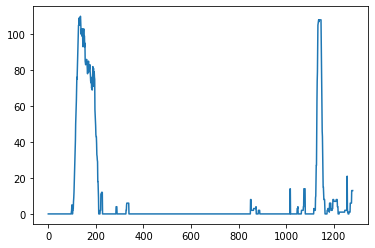

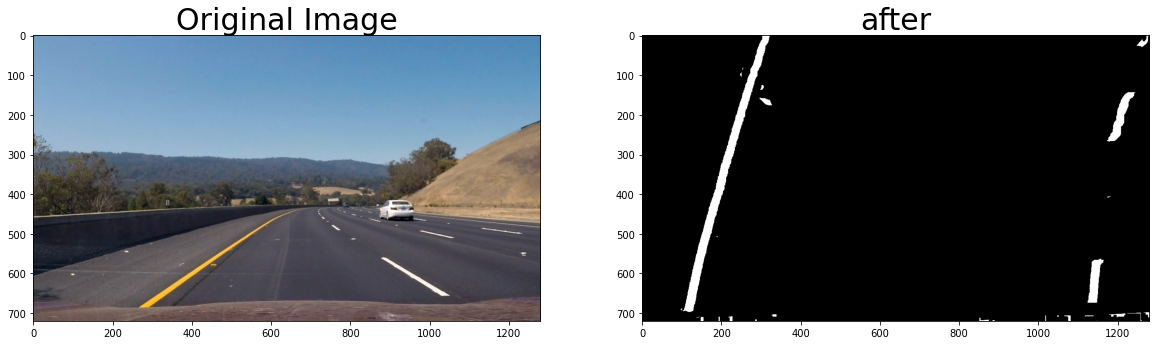

In [18]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a4mask= pipeline(img)
histogram = get_hist(a4mask)
# show_image(mask)
plt.plot(histogram)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(a4mask, cmap='gray')
ax2.set_title('after', fontsize=30)

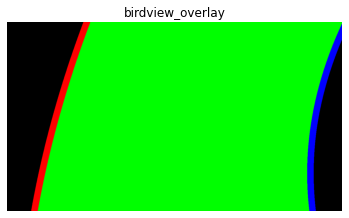

In [19]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(a4mask)
img_,birdview_curve = draw_lanes(img, curves[0], curves[1],ploty)
plt.imshow(img_, cmap='hsv')
show_image(birdview_curve,"birdview_overlay")

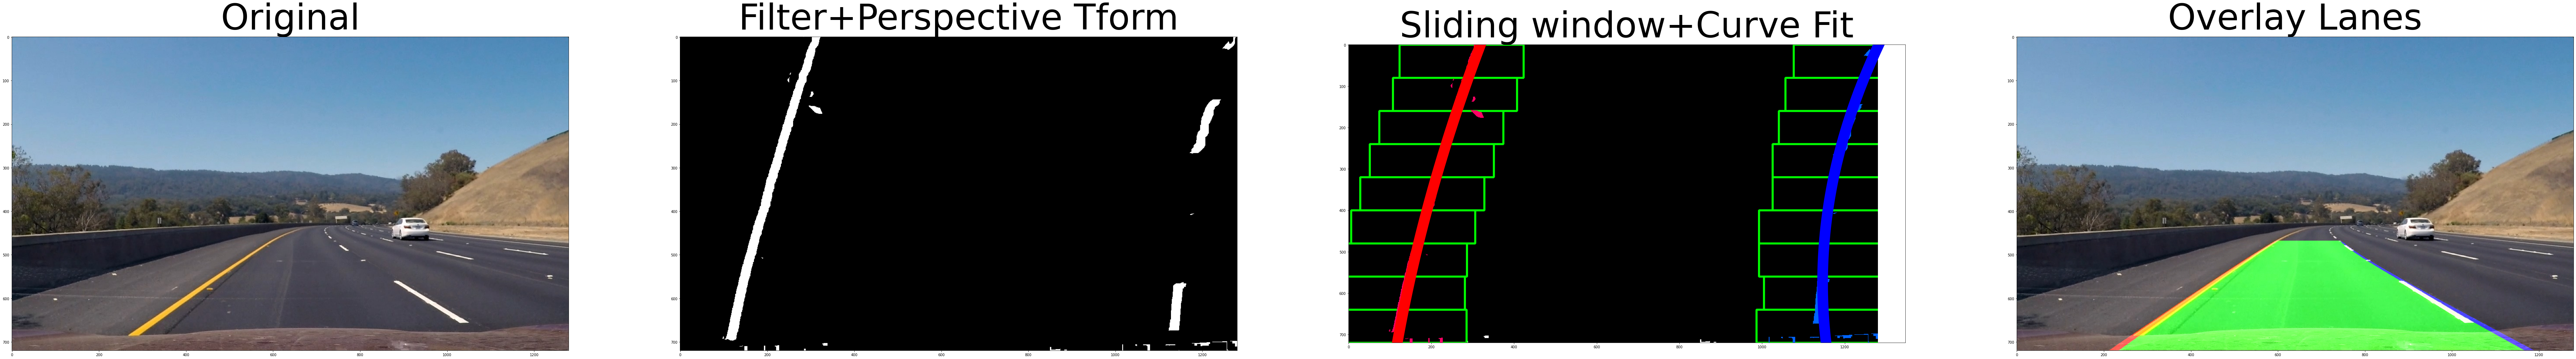

In [20]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(a4mask,'gray')
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='red', linewidth=30)
ax3.plot(curves[1], ploty, color='blue', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [23]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip
myclip = VideoFileClip('project_video.mp4')#.subclip(40,43)
output_vid = 'final_fady_project.mp4'
clip = myclip.fl_image(final_output)
clip.write_videofile(output_vid, fps =25,audio=False)

                                                                                                                       
t:   5%|███▍                                                               | 65/1260 [02:02<03:59,  4.99it/s, now=None]
                                                                                                                       
t:   8%|█████▏                                                             | 97/1260 [00:30<02:08,  9.08it/s, now=None]

Moviepy - Building video final_fady_project.mp4.
Moviepy - Writing video final_fady_project.mp4





t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

t:   0%|                                                                    | 2/1260 [00:00<01:42, 12.32it/s, now=None]

t:   0%|▏                                                                   | 4/1260 [00:00<02:04, 10.07it/s, now=None]

t:   0%|▎                                                                   | 6/1260 [00:00<01:57, 10.69it/s, now=None]

t:   1%|▍                                                                   | 8/1260 [00:00<02:03, 10.10it/s, now=None]

t:   1%|▌                                                                  | 10/1260 [00:00<01:57, 10.63it/s, now=None]

t:   1%|▋                                                                  | 12/1260 [00:01<01:54, 10.88it/s, now=None]

t:   1%|▋                                                                  | 14/1260 [00:01<02:01, 10.21it/s, now=None]

t:   1%|▊                     

t:  18%|███████████▋                                                      | 224/1260 [00:21<01:42, 10.08it/s, now=None]

t:  18%|███████████▊                                                      | 225/1260 [00:22<01:44,  9.94it/s, now=None]

t:  18%|███████████▊                                                      | 226/1260 [00:22<01:46,  9.71it/s, now=None]

t:  18%|███████████▉                                                      | 227/1260 [00:22<01:47,  9.65it/s, now=None]

t:  18%|███████████▉                                                      | 228/1260 [00:22<01:47,  9.62it/s, now=None]

t:  18%|███████████▉                                                      | 229/1260 [00:22<01:48,  9.48it/s, now=None]

t:  18%|████████████                                                      | 230/1260 [00:22<01:51,  9.22it/s, now=None]

t:  18%|████████████                                                      | 231/1260 [00:22<01:51,  9.20it/s, now=None]

t:  18%|████████████▏           

t:  33%|█████████████████████▌                                            | 411/1260 [00:41<01:25,  9.92it/s, now=None]

t:  33%|█████████████████████▌                                            | 412/1260 [00:41<01:26,  9.85it/s, now=None]

t:  33%|█████████████████████▋                                            | 413/1260 [00:41<01:27,  9.69it/s, now=None]

t:  33%|█████████████████████▋                                            | 414/1260 [00:41<01:27,  9.64it/s, now=None]

t:  33%|█████████████████████▊                                            | 416/1260 [00:41<01:20, 10.44it/s, now=None]

t:  33%|█████████████████████▉                                            | 418/1260 [00:41<01:23, 10.11it/s, now=None]

t:  33%|██████████████████████                                            | 420/1260 [00:41<01:24,  9.98it/s, now=None]

t:  33%|██████████████████████                                            | 422/1260 [00:42<01:26,  9.65it/s, now=None]

t:  34%|██████████████████████▏ 

t:  51%|█████████████████████████████████▍                                | 638/1260 [01:02<01:00, 10.30it/s, now=None]

t:  51%|█████████████████████████████████▌                                | 640/1260 [01:02<00:59, 10.44it/s, now=None]

t:  51%|█████████████████████████████████▋                                | 642/1260 [01:02<00:59, 10.42it/s, now=None]

t:  51%|█████████████████████████████████▋                                | 644/1260 [01:02<00:57, 10.77it/s, now=None]

t:  51%|█████████████████████████████████▊                                | 646/1260 [01:02<00:56, 10.89it/s, now=None]

t:  51%|█████████████████████████████████▉                                | 648/1260 [01:03<01:00, 10.17it/s, now=None]

t:  52%|██████████████████████████████████                                | 650/1260 [01:03<01:06,  9.20it/s, now=None]

t:  52%|██████████████████████████████████                                | 651/1260 [01:03<01:15,  8.11it/s, now=None]

t:  52%|████████████████████████

t:  67%|████████████████████████████████████████████                      | 842/1260 [01:22<00:38, 10.88it/s, now=None]

t:  67%|████████████████████████████████████████████▏                     | 844/1260 [01:22<00:39, 10.63it/s, now=None]

t:  67%|████████████████████████████████████████████▎                     | 846/1260 [01:22<00:38, 10.79it/s, now=None]

t:  67%|████████████████████████████████████████████▍                     | 848/1260 [01:22<00:37, 10.87it/s, now=None]

t:  67%|████████████████████████████████████████████▌                     | 850/1260 [01:23<00:37, 10.91it/s, now=None]

t:  68%|████████████████████████████████████████████▋                     | 852/1260 [01:23<00:36, 11.07it/s, now=None]

t:  68%|████████████████████████████████████████████▋                     | 854/1260 [01:23<00:37, 10.97it/s, now=None]

t:  68%|████████████████████████████████████████████▊                     | 856/1260 [01:23<00:36, 10.93it/s, now=None]

t:  68%|████████████████████████

t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [01:44<00:17, 10.62it/s, now=None]

t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [01:44<00:18, 10.06it/s, now=None]

t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [01:44<00:18, 10.06it/s, now=None]

t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [01:44<00:18,  9.93it/s, now=None]

t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [01:44<00:17, 10.07it/s, now=None]

t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [01:45<00:17,  9.89it/s, now=None]

t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [01:45<00:17, 10.28it/s, now=None]

t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [01:45<00:16, 10.28it/s, now=None]

t:  86%|████████████████████████

Moviepy - Done !
Moviepy - video ready final_fady_project.mp4


In [22]:
def sobel_filter(img,s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    ####################################################################################
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

# def canny_filter(img,threshold=(30,255),s_thresh=(100, 255), l_thresh=(120, 255)):
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     height, width = gray.shape
#     canny = cv2.Canny(gray,threshold[0],threshold[1])
#     # R & G thresholds so that yellow lanes are detected well.
#     color_threshold = 150
#     R = img[:,:,0]
#     G = img[:,:,1]
#     color_combined = np.zeros_like(R)
#     r_g_condition = (R > color_threshold) & (G > color_threshold)
    
#     # Apply color threshold for better detection of yello and white lines in all environmental condition
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     # Select S channel because it is usually the best performant
#     # for this task. R channel also performs similarly.
#     s_channel = hls[:,:,2] 
#     l_channel = hls[:,:,1]
    
#      # S channel performs well for detecting bright yellow and white lanes
#     s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
#     # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.   
#     l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
#     # combine all the thresholds
#     # A pixel should either be a yellowish or whiteish
#     # And it should also have a gradient, as per our thresholds
#     color_combined[(r_g_condition & l_condition) & (s_condition | canny)] = 1
    
#     #binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
#     # apply the region of interest mask
#     mask = np.zeros_like(color_combined)
#     region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
#     cv2.fillPoly(mask, [region_of_interest_vertices], 1)
#     thresholded = cv2.bitwise_and(color_combined, mask)

#     return canny
# def canny_filter(img,threshold=(20,150)):
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     hist = cv2.equalizeHist(gray)
#     canny = cv2.Canny(hist,threshold[0],threshold[1])
#     return canny

In [ ]:
img = images[5]
img2 = sobel_filter(img)
height,width = img2.shape
# apply the region of interest mask
mask = np.zeros_like(img2)
region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_interest_vertices], 1)
img2 = cv2.bitwise_and(img2, mask)
img2 = perspective_transform(img2, dst_size=(1280,720),inv=0)
histogram = get_hist(img2)
plt.plot(histogram)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 20))
ax1.imshow(img)
ax2.imshow(img2,'gray')

In [ ]:

# img = images[2]
# img_canny = canny_filter(img)
# height, width = img_canny.shape
# mask = np.zeros_like(img_canny)
# region_of_interest_vertices = np.array([[0,0.9*(height-1)], [width/2, int(0.6*height)], [width-1,0.9*( height-1)]], dtype=np.int32)
# cv2.fillPoly(mask, [region_of_interest_vertices], 1)
# img_canny = cv2.bitwise_and(img_canny, mask)
# histogram = get_hist(img_canny)

# # show_image(mask)
# plt.plot(histogram)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 20))
# ax1.imshow(img)
# ax2.imshow(img_canny,'gray')